In [1]:
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.feature_selection import RFE
import pickle
from IPython.core.display import HTML
#import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

<div class="span5 alert alert-info">
<h2>Note book details</h2>

<p> This notebook is for <b>Logistic Regression</b> for <b>kickstarter success prediction</b> project.</p>

<p> Notes.</p>
<ol>
<li>Perform baseline analysis </li>
<li>Perform feature important analysis </li>
<li> Apply logistic regression alogrithm to the data
    <ul>
     <li>Extract Confusion matrix for logistic regression </li>
     <li>Extract clasification report for logistic regression </li>
    </ul>
</li>        
</ol>
</div>

In [2]:
pd.set_option('display.max_colwidth', -1)
color_success='#00ff66'#kickstarter green#'#2BDE73'
color_fail='#FF192F'#'#FFC7CE'#'#FFC7CE'#'#FF0000' # red
stateSuccess='Successful'
stateFail='Failed'

In [3]:
# from IPython.core.display import HTML
css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
cssAnalysis = '.analysis {background:#5bffc0; }' 
csstable ='#wrapper table {margin: auto;background-color:#FDFBE8;border-color:#000000;border-style:solid;border-width:1px;border-spacing: 0px;padding: 0px;}'
csstable2='#content table td {border-style: solid; border-width: 1px; width: 50px; text-align: center;  }'
HTML('<style>{} {} {} {}</style>'.format(css,cssAnalysis,csstable,csstable2))
pickle_file='DataStory_Jan2017_Jan2018.sa'
df_final_months = pickle.load( open( pickle_file, "rb" ) )
#df_final_months.info()
#df_final_months.head()

In [4]:
# filter out suspened, cancleed and live projects
df_fail_success_prior= df_final_months[(df_final_months.state==stateSuccess) | (df_final_months.state==stateFail)]
_=df_fail_success_prior.set_index('project_id')
#df_fail_success.head()

In [5]:
df_fail_success=df_fail_success_prior.loc[:,['state','category','country','location_type','backers_count','staff_pick','usd_pledged','deadline_days']]
_=df_fail_success['staff_pick']= df_fail_success['staff_pick']*1

## Helper methods

In [6]:
def AddDummyColumnsToDataFrame(dfinput,colname,removelastdummy=False):
    print('Add {}'.format(colname))
    temp =pd.get_dummies(dfinput[colname])
    # remove one column from dummies with least value.
    if removelastdummy:
        t=dfinput.groupby(colname).count().state
        col_name=((t[t.values==t.min()]).index).get_values()[0]
        if col_name in temp.columns:
            print('removed column {}'.format(col_name))
            temp=temp.drop([col_name], axis=1)
    
    # remove the main column after extracting dummy
    if colname in dfinput.columns:
        print('removed column {}'.format(colname))
        dfinput =dfinput.drop([colname], axis=1)
    
    return  pd.concat([dfinput,temp], axis=1,ignore_index=False)

In [7]:
def ModifyingColumnToLabel(df,colname):
    lab_enc = preprocessing.LabelEncoder()
    _=lab_enc.fit(df[colname])
    new_val = lab_enc.transform(df[colname])
    _=df.loc[:, '{}_val'.format(colname)] = new_val

In [8]:
def GetNFeaturesForImportance(cofficent,n=5):
    i=0
    column_cofficent = {}
    for element in np.nditer(cofficent):#featureimportance[0]:
        #for e in element:
        #print(('{0:.6f}').format(element))
        #print((element))
        column_cofficent[collist[i]]=float(element)
        i=i+1

    column_cofficent = [(k, column_cofficent[k]) for k in sorted(column_cofficent, key=column_cofficent.get, reverse=True)]
    #print(type(column_cofficent))
    positive_column_cofficent=column_cofficent[:n]
    negative_column_cofficent=column_cofficent[(-n):]
    positive_column_cofficent=pd.DataFrame(positive_column_cofficent)
    positive_column_cofficent=positive_column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    #positive_column_cofficent.set_index('feature',inplace=True)
    negative_column_cofficent=pd.DataFrame(negative_column_cofficent)
    negative_column_cofficent=negative_column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    #negative_column_cofficent.set_index('feature',inplace=True)
    column_cofficent=pd.DataFrame(column_cofficent)
    column_cofficent=column_cofficent.rename(columns={0:'feature',1:'Cofficent'})
    
    return(positive_column_cofficent,negative_column_cofficent,column_cofficent)

In [9]:
def GetClassificationReport(yTrain, y_predict_training,ytestlr, y_predict_test, prefix=""):

    print(prefix + " [Training Classification Report:]"  )
    print('yTrain length= {}'.format( len(yTrain)))
    print('y_predict_training length= {}'.format( len(y_predict_training)))

    print(classification_report(yTrain, y_predict_training))

    print(prefix +"[Test Classification Report:]")
    print('ytestlr length= {}'.format( len(ytestlr)))
    print('y_predict_test length= {}'.format( len(y_predict_test)))
    
    print(classification_report(ytestlr, y_predict_test))

In [10]:
def GetConfusionMatrix(ytestlr, y_predict_test,prefix=""):
    print(prefix +"[GetConfusion Matrix Report:]")
    cm = confusion_matrix(ytestlr, y_predict_test)
    print(cm)

In [11]:
def cv_optimize(clf, parameters, Xtrain, yTrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, yTrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [12]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    #subdf[subdf.index.duplicated()]
    #if standardize:
        #print(featurenames)
    #    subdfstd=(subdf - subdf.mean())/subdf.std()
    #else:
     #   subdfstd=subdf
    subdfstd=subdf    
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtestlr, yTrain, ytestlr = train_test_split(X, y, train_size=train_size, random_state=5)
    
    clf = cv_optimize(clf, parameters, Xtrain, yTrain)
    if standardize:
        print('This is standard feature fit')
        clf=clf.fit(Xtrain / np.std(Xtrain, 0), yTrain) # with standardized parameters:
    else:
        print('This is normal fit')
        clf=clf.fit(Xtrain, yTrain) # without standardized parameters:
    
    training_accuracy = clf.score(Xtrain, yTrain)
    test_accuracy = clf.score(Xtestlr, ytestlr)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
   
    return clf, Xtrain, yTrain, Xtestlr, ytestlr

In [13]:
# Convert category columns to dummy columns
categoryColumns=['category','country','location_type']
for col in categoryColumns:
    print(col)
    df_fail_success=AddDummyColumnsToDataFrame(df_fail_success,col)

#df_fail_success.info()

category
Add category
removed column category
country
Add country
removed column country
location_type
Add location_type
removed column location_type


In [14]:
# remove columns not required 
for col_name in ['project_id','category','country','location_type','usd_goal']:
    if col_name in df_fail_success.columns:
            print('removed column {}'.format(col_name))
            df_fail_success=df_fail_success.drop([col_name], axis=1)

In [15]:
hyperparam =[0.01, 0.1, 1, 10, 100]
#hyperparam =[0.01, 0.015, 0.020, 0.025]

In [16]:
# Rename columns by removing single quote(') and replace space with underscore(_) 
i=0
colnamelist=''
for col in df_fail_success.columns:
    i=i+1
    oldcolname=col
#if oldcolname.find(' ')>=0:
    newcolname=oldcolname.replace(' ','_').replace("'",'')
#if oldcolname.find("'")>=0:
    #newcolname=oldcolname.replace("'",'')
    if(oldcolname!=newcolname):
        df_fail_success = df_fail_success.rename(columns={oldcolname: newcolname})
        #print('new column name is ' + newcolname)
        #print('old column name is ' + oldcolname)
        
    if col !='state':
        #print(("'{}',").format(col))
        #colnamelist=colnamelist+("'{}',").format(col)
        colnamelist=colnamelist+('{},').format(newcolname)
        
print(i)
#print(colnamelist)

178


In [17]:
# create list of coulms for logistic regression
collist =colnamelist.split(",")
collist.remove('')
len(collist)
#len(df_fail_success.columns)
#collist
#list(df_fail_success)
#collist

177

## Logistic Regression Implementation

<div class="span5 alert alert-info">
<h4>Running logistic regression and finding out classification report and confusion matrix </h4>
</div>

In [18]:
# logistic regression to find classification report and confusion matrix
clf_1, Xtrain_1, yTrain_1, Xtestlr_1, ytestlr_1  = do_classify(LogisticRegression(), 
                                                           {"C": hyperparam}, 
                                                           df_fail_success, collist, 'state',stateSuccess,False)
# predict on training set
y_predict_training_1 = clf_1.predict(Xtrain_1)

# predict on test set
y_predict_test_1 = clf_1.predict(Xtestlr_1)
#print("Correlation coefficient of LogisticRegression")
#cofficent=clf.coef_ 
#print(cofficent )
#print("Feature importance from Correlation coefficient of LogisticRegression")
#standarddeviation = np.std(Xtrain, 0)
#featureimportance =standarddeviation*clf.coef_
#print(featureimportance)
GetClassificationReport(yTrain_1, y_predict_training_1,ytestlr_1, y_predict_test_1)
GetConfusionMatrix(ytestlr_1, y_predict_test_1,"1")


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.01}
This is normal fit
Accuracy on training data: 0.82
Accuracy on test data:     0.83
 [Training Classification Report:]
yTrain length= 126194
y_predict_training length= 126194
             precision    recall  f1-score   support

          0       0.78      0.92      0.85     66280
          1       0.89      0.71      0.79     59914

avg / total       0.83      0.82      0.82    126194

[Test Classification Report:]
ytestlr length= 31549
y_predict_test length= 31549
             precision    recall  f1-score   support

          0       0.78      0.92      0.85     16616
          1       0.89      0.72      0.80     14933

avg / total       0.84      0.83      0.82     31549

1[GetConfusion Matrix Report:]
[[15336  1280]
 [ 4236 10697]]


<div class="span5 alert alert-info">

<h4>Running logistic regression and feature importance analysis</h4>
</div>

In [19]:
# Run regression to find out important feature using standardize parameters

clf, Xtrain, yTrain, Xtestlr, ytestlr  = do_classify(LogisticRegression(), 
                                                           {"C": hyperparam}, 
                                                           df_fail_success, collist, 'state',stateSuccess,True)

# predict on training set
y_predict_training = clf.predict(Xtrain)

# predict on test set
y_predict_test = clf.predict(Xtestlr)
print("Feature importance coefficient of LogisticRegression")
cofficent=clf.coef_ 
print(cofficent)
#print("Feature importance from Correlation coefficient of LogisticRegression")
#standarddeviation = np.std(Xtrain, 0)
#featureimportance =standarddeviation*clf.coef_
#print(featureimportance)
#GetClassificationReport(yTrain, y_predict_training,ytestlr, y_predict_test)
#GetConfusionMatrix(ytestlr, y_predict_test,"1")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.01}
This is standard feature fit
Accuracy on training data: 0.60
Accuracy on test data:     0.59
Feature importance coefficient of LogisticRegression
[[  5.51873656e+00   3.58877223e-01   4.36929332e+00  -2.87341996e-01
   -6.03696925e-02  -4.89153938e-02  -7.32176958e-02  -7.88342632e-02
   -2.87551139e-02  -1.06841156e-01   1.78622673e-02  -1.53026126e-01
   -3.43432746e-01  -5.03045265e-02  -1.11059034e-02  -3.74436676e-02
   -3.22609833e-02   4.11589922e-03  -9.75958475e-03  -3.53164539e-02
   -6.60179179e-02  -9.01308191e-03  -5.89485612e-03  -5.73869237e-02
    1.86948723e-02  -2.53816797e-02   1.01283376e-01  -2.54433978e-02
    5.31885325e-02  -3.19381272e-02  -1.99690583e-02  -5.47443964e-02
    1.17755022e-01  -3.71674350e-02  -2.83723152e-02  -8.92569221e-02
   -1.47819731e-02  -5.24985235e-02   7.82678351e-01  -1.90076976e-02
   -1.10677142e-01  -2.95346773e-02  -2.96137645e-02  -6.96385991e-02
   -1.02596823e-02  -4.40295209e-02  -2.29501368e-03  -4.570

In [20]:
five_success_column_cofficent,five_fail_column_cofficent,column_cofficent=GetNFeaturesForImportance(cofficent)
success_column_cofficent=column_cofficent[column_cofficent.Cofficent>0]
fail_column_cofficent=column_cofficent[column_cofficent.Cofficent<=0]
print('Top 5 feature with towards success(1) : positive values')
print(five_success_column_cofficent.feature)

print('Top 5 feature with towards fail(0) : negative values')
print(five_fail_column_cofficent.feature)

Top 5 feature with towards success(1) : positive values
0    backers_count 
1    usd_pledged   
2    Shorts        
3    Documentary   
4    Tabletop_Games
Name: feature, dtype: object
Top 5 feature with towards fail(0) : negative values
0    Restaurants  
1    Software     
2    Web          
3    deadline_days
4    Apps         
Name: feature, dtype: object


<div class="span5 alert alert-info">
<h4>Top 5 feature with towards success(1) : positive values</h4>
    <ul>
     <li>backers_count  </li>
     <li> usd_pledged </li>
     <li> Shorts         </li>
     <li> Documentary    </li>
     <li> Tabletop Games </li>
    </ul>
    <br/>
<h4>Top 5 feature with towards fail(0) : negative values</h4>
    <ul>
     <li>Restaurants    </li>
     <li> Software </li>
     <li>  Web         </li>
     <li> deadline_days    </li>
     <li> Apps  </li>
    </ul>    
</div>

In [42]:
def MultipleSplitMethod(df,featurenames,targetname, targetval,parameters,n_splits=1000,train_size=0.8):
    training_accuracy = []
    test_accuracy = []
    accuracy_difference = []
    max_accuracy_yTrain= max_accuracy_y_predict_training=max_accuracy_ytestlr= max_accuracy_y_predict_test=max_accuracy_diff=0
    min_accuracy_yTrain= min_accuracy_y_predict_training=min_accuracy_ytestlr= min_accuracy_y_predict_test=min_accuracy_diff=0

    clf = LogisticRegression()

    # loop over multiple trials
    for i in range(0, n_splits):
        #print('npspli count {}'.format(i))
        # do split for this iteration, using shuffle and a different random_state 
        # for every iteration
        Xtrain, Xtestlr, yTrain, ytestlr = train_test_split(df[featurenames].values, 
                                                  (df[targetname] == targetval).values,random_state=i, train_size=train_size)
        # fit on the training set
        #clf.fit(Xtrain, yTrain) # updated this step gridsearch
        #clf = cv_optimize(clf, parameters, Xtrain, yTrain)
        clf=clf.fit(Xtrain, yTrain) # without standardized parameters:
        #clf=clf.fit(Xtrain / np.std(Xtrain, 0), yTrain) # with standardized parameters:

        # predict on training set
        y_predict_training = clf.predict(Xtrain)

        # predict on test set
        y_predict_test = clf.predict(Xtestlr)

        # save training accuracy for this split
        tr_accuracy = accuracy_score(y_predict_training, yTrain)
        training_accuracy.append(tr_accuracy)

        # save test accuracy for this split
        tst_accuracy = accuracy_score(y_predict_test, ytestlr)
        test_accuracy.append(tst_accuracy)

        # save difference
        accuracy_diff=tst_accuracy - tr_accuracy
        accuracy_difference.append(accuracy_diff)
        if accuracy_diff>max_accuracy_diff:
            #print("Min Accuracy values--> npspli :{} ,tr_accuracy : {}, tst_accuracy : {}, accuracy diff : {} ,  ytrain : {} ,  y_predict_training: {},  ytestlr: {},  y_predict_test: {} , "
            #      .format(i,tr_accuracy,tst_accuracy,accuracy_diff,yTrain,y_predict_training,ytestlr,y_predict_test))
            max_accuracy_diff=accuracy_diff
            max_accuracy_yTrain=yTrain
            max_accuracy_y_predict_training=y_predict_training
            max_accuracy_ytestlr=ytestlr
            max_accuracy_y_predict_test=y_predict_test
            #print("Correlation coefficient of LogisticRegression - max")
            #print(clf.coef_ )

        if accuracy_diff<min_accuracy_diff:
            #print("Min Accuracy values--> npspli :{} ,tr_accuracy : {}, tst_accuracy : {}, accuracy diff : {} ,  ytrain : {} ,  y_predict_training: {},  ytestlr: {},  y_predict_test: {} , "
            #     .format(i,tr_accuracy,tst_accuracy,accuracy_diff,yTrain,y_predict_training,ytestlr,y_predict_test))
            min_accuracy_diff=accuracy_diff
            min_accuracy_yTrain=yTrain
            min_accuracy_y_predict_training=y_predict_training
            min_accuracy_ytestlr=ytestlr
            min_accuracy_y_predict_test=y_predict_test
            #print("Correlation coefficient of LogisticRegression - min")
            #print(clf.coef_ )

    '''GetClassificationReport(min_accuracy_yTrain, min_accuracy_y_predict_training,min_accuracy_ytestlr, min_accuracy_y_predict_test,"Min")
    GetClassificationReport(max_accuracy_yTrain, max_accuracy_y_predict_training,max_accuracy_ytestlr, max_accuracy_y_predict_test,"Max")
    GetConfusionMatrix(min_accuracy_ytestlr, min_accuracy_y_predict_test,"Min")
    GetConfusionMatrix(max_accuracy_ytestlr, max_accuracy_y_predict_test,"Max")'''
    
    return  (training_accuracy,test_accuracy,accuracy_difference)

In [29]:
def DrawTrainingTestAccuracyplot(accuracy_difference):
    training_plot, = plt.plot(training_accuracy, 'b')
    test_plot, = plt.plot(test_accuracy, 'r', alpha = 0.35)
    plt.legend([training_plot, test_plot], ['Training Accuracy', 'Test Accuracy'])
    plt.ylabel('Training vs Test Accuracy')
    plt.show()

In [30]:
def DrawTrainingTestAccuracyDifferenceplot(accuracy_difference):
    diff_plot, = plt.plot(accuracy_difference, 'y')
    plt.legend([diff_plot], ['Difference'])
    plt.ylabel('Test/Training Difference Accuracy')
    plt.show()

### Running test with muliple set

In [44]:
print(datetime.now())
training_accuracy,test_accuracy,accuracy_difference=MultipleSplitMethod(df_fail_success, collist, 'state',stateSuccess,{"C": hyperparam},1000)
print(datetime.now())

2018-04-16 13:32:37.284880


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


2018-04-16 13:50:24.193272


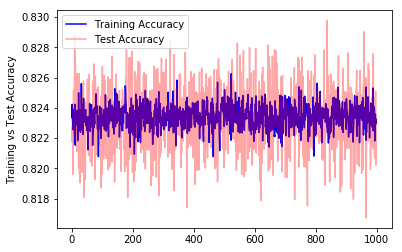

In [45]:
DrawTrainingTestAccuracyplot(accuracy_difference)

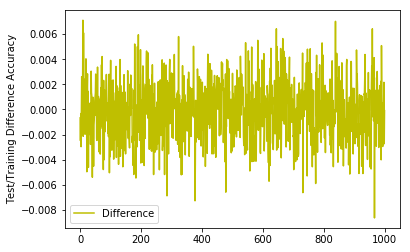

In [46]:
DrawTrainingTestAccuracyDifferenceplot(accuracy_difference)

In [21]:
### Box and Whisker plots for feature importance

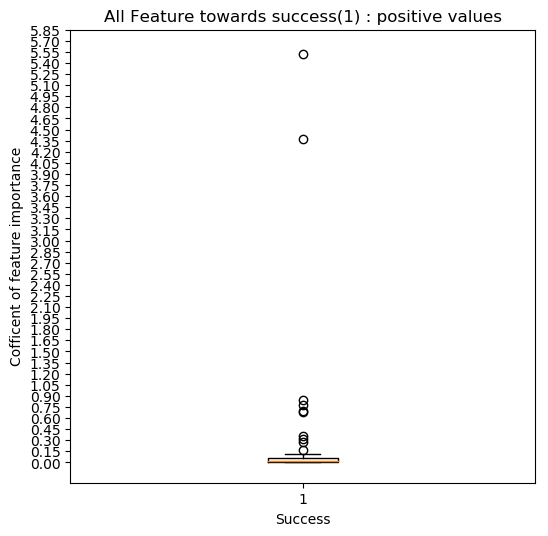

In [22]:
# Box and whsiker plot for all feature adding toward result of Success( 1)
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(success_column_cofficent.Cofficent)

_=ax.set_yticks(np.arange(0,6,0.15))
_ =ax.set_xlabel('Success')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('All Feature towards success(1) : positive values')


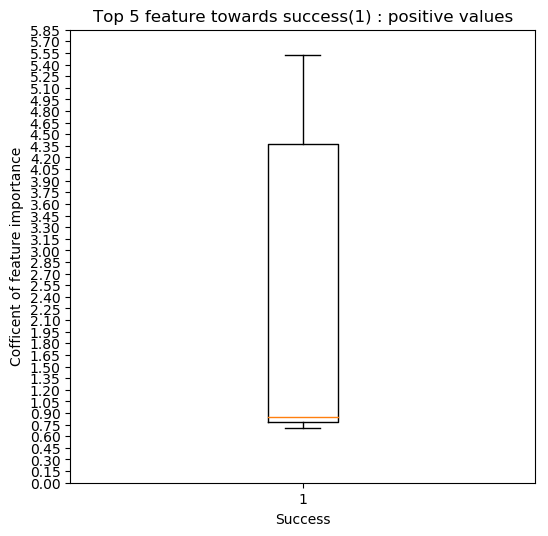

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(five_success_column_cofficent.Cofficent)

_=ax.set_yticks(np.arange(0,6,0.15))
_ =ax.set_xlabel('Success')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('Top 5 feature towards success(1) : positive values')

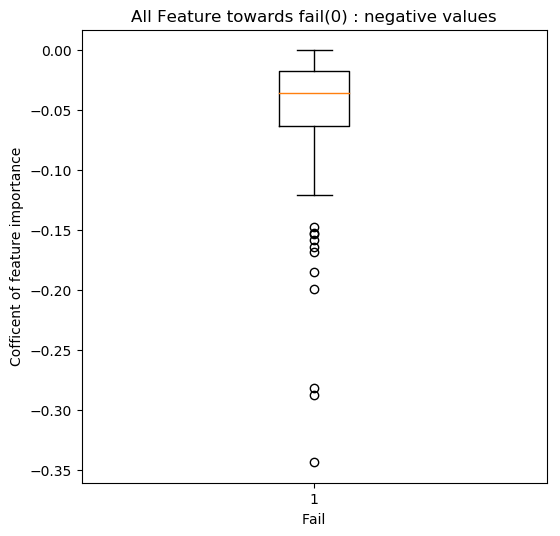

In [24]:
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
#_=ax.set_yticks(np.arange(0,6,0.15))
bp=ax.boxplot(fail_column_cofficent['Cofficent'].values)
_ =ax.set_title('All Feature towards fail(0) : negative values')
#_=ax.set_yticks([0,6,0.0005])
_ =ax.set_xlabel('Fail')
_= ax.set_ylabel('Cofficent of feature importance')

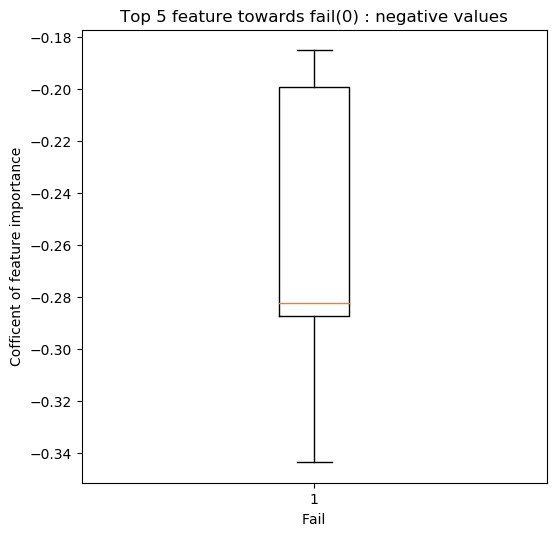

In [25]:
#ax=sns.boxplot(data=five_fail_column_cofficent, orient="h", palette="Set2")
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=100)
bp=ax.boxplot(five_fail_column_cofficent.Cofficent)

#_=ax.set_yticks([0,6,0.0005])
_ =ax.set_xlabel('Fail')
_= ax.set_ylabel('Cofficent of feature importance')
_ =ax.set_title('Top 5 feature towards fail(0) : negative values')

In [26]:
## End